# IS424: Data Mining & Biz Analytics
## Team: G3T3
### Project: Predicting Loan Default based on Customer Profile
### Grid Search and Cross-validation: RandomForest
---

# 1. Setting up the notebook

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from category_encoders import TargetEncoder

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, fbeta_score, accuracy_score, roc_auc_score

In [2]:
df_train = pd.read_csv("../dataset/train.csv")
df_test = pd.read_csv("../dataset/test.csv")

y_train = df_train[["risk_flag"]]
x_train = df_train.drop("risk_flag", axis=1)

y_test = df_test[["risk_flag"]]
x_test = df_test.drop("risk_flag", axis=1)

In [3]:
x_train.head()

,income,age,experience,marital_status,car_ownership,profession,city,state,rented
0,3278154,56,20,1,0,Technology_specialist,Gorakhpur,Uttar_Pradesh,1.0
1,1315700,53,4,1,0,Civil_engineer,Thoothukudi,Tamil_Nadu,1.0
2,5021070,47,20,1,0,Magistrate,Khammam,Telangana,1.0
3,2824175,54,0,1,0,Chef,Serampore,West_Bengal,1.0
4,8790456,41,2,1,0,Designer,Tiruppur,Tamil_Nadu,1.0


# 2. Performance of Base Random Forest Classifier

In [4]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer

def cv_evaluate_model(rf_clf):
    te_features = ['profession', 'city','state']
    scale_features = ['income','age','experience']

    preprocessor = ColumnTransformer(transformers=[('te_features', TargetEncoder(), te_features),
                                                    ('scale_features', MinMaxScaler(), scale_features)])

    pipeline = Pipeline(steps = [['preprocessor', preprocessor ],
                                 ['smote', SMOTE(random_state=2021)],
                                 ['classifier', rf_clf]
                                ])
    
    stratified_kfold = StratifiedKFold(shuffle=True, n_splits=3, random_state=2021)

    scoring = {"recall": 'recall',
               "fbeta_2": make_scorer(fbeta_score, beta=2),
               "roc_auc": make_scorer(roc_auc_score),
              }

    scores = cross_validate(pipeline, x_train, y_train.values.ravel(), cv=stratified_kfold,
                           scoring = scoring)

    recall = [ val for val in scores['test_recall'] ]
    fbeta_2 = [ val for val in scores['test_fbeta_2'] ]
    auc = [ val for val in scores['test_roc_auc'] ]
    recall.append( sum(recall) / len(recall) )
    fbeta_2.append( sum(fbeta_2) / len(fbeta_2) )
    auc.append( sum(auc) / len(auc) )

    score_df = pd.DataFrame(data=[recall, fbeta_2, auc], columns=['Fold 1','Fold 2','Fold 3', 'Average'],
                            index=['Recall','Fbeta2','AUC'])
    return score_df

In [5]:
base_rf_clf = RandomForestClassifier(random_state=2021)
results_base = cv_evaluate_model(base_rf_clf)
display(results_base)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Fold 1,Fold 2,Fold 3,Average
Recall,0.787054,0.785870,0.781273,0.784732
Fbeta2,0.718181,0.717600,0.715457,0.717079
AUC,0.844973,0.844559,0.843041,0.844191


# 3. Hyper parameter tuning with GridSearch

## 3.1 Conducting Grid Search 1

In [6]:
# Creating parameter grid to search
n_estimators = [100, 500, 900]

max_depth = [5, 10, 15]

min_samples_split = [3, 5, 8]

min_samples_leaf = [1, 3, 5]

params_grid = {
                'classifier__n_estimators': n_estimators,
                'classifier__min_samples_split': min_samples_split,
                'classifier__min_samples_leaf': min_samples_leaf,
                'classifier__max_depth': max_depth
              }

total_combi = 1
for param, value in params_grid.items():
    print(param, value)
    total_combi *= len(value)

print('-----------------')
print('Total combinations:', total_combi)

classifier__n_estimators [100, 500, 900]
classifier__min_samples_split [3, 5, 8]
classifier__min_samples_leaf [1, 3, 5]
classifier__max_depth [5, 10, 15]
-----------------
Total combinations: 81


In [7]:
# # conduct gridsearch 1
# te_features = ['profession', 'city','state']
# scale_features = ['income','age','experience']

# preprocessor = ColumnTransformer(transformers=[('te_features', TargetEncoder(), te_features),
#                                                 ('scale_features', MinMaxScaler(), scale_features)])

# pipeline = Pipeline(steps = [['preprocessor', preprocessor ],
#                              ['smote', SMOTE(random_state=2021)],
#                              ['classifier', RandomForestClassifier(random_state=2021)]
#                             ])

# stratified_kfold = StratifiedKFold(shuffle=True, n_splits=3, random_state=2021)


# rf_gridsearch = GridSearchCV(estimator = pipeline,
#                            param_grid = params_grid,
#                            scoring = 'recall',
#                            cv = stratified_kfold,
#                            refit = True,
#                            n_jobs = -1)

# rf_gridsearch.fit( x_train, y_train.values.ravel() )
# best_parameters = rf_gridsearch.best_params_
# print(best_parameters)

{'classifier__max_depth': 15, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 100}

In [8]:
# classifier trained on the latest hyper parameters
rf_clf = RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=3,
                                min_samples_split=3, n_estimators=100,
                                random_state=2021)

results_gs1 = cv_evaluate_model(rf_clf)
display(results_gs1)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Fold 1,Fold 2,Fold 3,Average
Recall,0.791410,0.788773,0.784055,0.788079
Fbeta2,0.704409,0.710596,0.702685,0.705896
AUC,0.837777,0.840996,0.836279,0.838351


## 3.2 Second GridSearchCV
This second parameter search space aims to narrow down the search space based on the results obtained in the first grid search.

**Previous parameter search space:**
- n_estimators = [100, 500, 900]
- max_depth = [5, 10, 15]
- min_samples_split = [3, 5, 8]
- min_samples_leaf = [1, 3, 5]

**Obtained results:**

| Feature           | Value | New search space |
|-------------------|:-----:|------------|
| n_estimators      | 100   | [100, 150, 200, 250, 300] |
| max_depth         | 15    | [13, 15, 17, 20] |
| min_samples_split | 3     | [2, 3, 4] |
| min_samples_leaf  | 3     | [2, 3, 4] |

In [9]:
# Creating parameter grid to search
n_estimators = [100, 150, 200, 250]

max_depth = [13, 15, 17, 20]

min_samples_split = [2, 3, 4]

min_samples_leaf = [2, 3, 4]

params_grid = {
                'classifier__n_estimators': n_estimators,
                'classifier__min_samples_split': min_samples_split,
                'classifier__min_samples_leaf': min_samples_leaf,
                'classifier__max_depth': max_depth
              }

total_combi = 1
for param, value in params_grid.items():
    print(param, value)
    total_combi *= len(value)

print('-----------------')
print('Total combinations:', total_combi)

classifier__n_estimators [100, 150, 200, 250]
classifier__min_samples_split [2, 3, 4]
classifier__min_samples_leaf [2, 3, 4]
classifier__max_depth [13, 15, 17, 20]
-----------------
Total combinations: 144


In [10]:
# # conduct gridsearch 2
# te_features = ['profession', 'city','state']
# scale_features = ['income','age','experience']

# preprocessor = ColumnTransformer(transformers=[('te_features', TargetEncoder(), te_features),
#                                                 ('scale_features', MinMaxScaler(), scale_features)])

# pipeline = Pipeline(steps = [['preprocessor', preprocessor ],
#                              ['smote', SMOTE(random_state=2021)],
#                              ['classifier', RandomForestClassifier(random_state=2021)]
#                             ])

# stratified_kfold = StratifiedKFold(shuffle=True, n_splits=3, random_state=2021)


# rf_gridsearch = GridSearchCV(estimator = pipeline,
#                            param_grid = params_grid,
#                            scoring = 'recall',
#                            cv = stratified_kfold,
#                            refit = True,
#                            n_jobs = -1)

# rf_gridsearch.fit( x_train, y_train.values.ravel() )
# best_parameters = rf_gridsearch.best_params_
# print(best_parameters)

{'classifier__max_depth': 15, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

In [11]:
# classifier trained on the latest hyper parameters
rf_clf2 = RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=3,
                                min_samples_split=2, n_estimators=100,
                                random_state=2021)

results_gs2 = cv_evaluate_model(rf_clf2)
display(results_gs2)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Fold 1,Fold 2,Fold 3,Average
Recall,0.791410,0.788773,0.784055,0.788079
Fbeta2,0.704409,0.710596,0.702685,0.705896
AUC,0.837777,0.840996,0.836279,0.838351


## 3.2 Second GridSearchCV
This second parameter search space aims to narrow down the search space based on the results obtained in the first grid search.

**Previous parameter search space:**
- n_estimators = [100, 500, 900]
- max_depth = [5, 10, 15]
- min_samples_split = [3, 5, 8]
- min_samples_leaf = [1, 3, 5]

- n_estimators = [100, 150, 200, 250]
- max_depth = [13, 15, 17, 20]
- min_samples_split = [2, 3, 4]
- min_samples_leaf = [2, 3, 4]

**Obtained results:**

{'classifier__max_depth': 15, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

| Feature           | GridSearch1 | GridSearch2 |      New search space     |
|-------------------|:-----------:|:-----------:|:-------------------------:|
| n_estimators      |100          |100          | [75, 90, 100, 110, 125, 135, 145] |
| max_depth         |15           |15           |         Leave as 15       |
| min_samples_split |3            |2            |         Leave as 2        |
| min_samples_leaf  |3            |3            |         Leave as 3        |

In [12]:
# Creating parameter grid to search
n_estimators = [50, 75, 90, 100, 110, 125, 135, 145]

params_grid = {
                'classifier__n_estimators': n_estimators,
              }

total_combi = 1
for param, value in params_grid.items():
    print(param, value)
    total_combi *= len(value)

print('-----------------')
print('Total combinations:', total_combi)

classifier__n_estimators [50, 75, 90, 100, 110, 125, 135, 145]
-----------------
Total combinations: 8


In [13]:
# # conduct gridsearch 3
# te_features = ['profession', 'city','state']
# scale_features = ['income','age','experience']

# preprocessor = ColumnTransformer(transformers=[('te_features', TargetEncoder(), te_features),
#                                                 ('scale_features', MinMaxScaler(), scale_features)])

# pipeline = Pipeline(steps = [['preprocessor', preprocessor ],
#                              ['smote', SMOTE(random_state=2021)],
#                              ['classifier', RandomForestClassifier(max_features='sqrt', max_depth=15, min_samples_split=2, min_samples_leaf=3, random_state=2021) ]
#                             ])

# stratified_kfold = StratifiedKFold(shuffle=True, n_splits=3, random_state=2021)


# rf_gridsearch = GridSearchCV(estimator = pipeline,
#                            param_grid = params_grid,
#                            scoring = 'recall',
#                            cv = stratified_kfold,
#                            refit = True,
#                            n_jobs = -1)

# rf_gridsearch.fit( x_train, y_train.values.ravel() )
# best_parameters = rf_gridsearch.best_params_
# print(best_parameters)

In [18]:
# classifier trained on the latest hyper parameters
rf_clf3 = RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=2,
                                min_samples_split=2, n_estimators=110,
                                random_state=2021)

results_gs3 = cv_evaluate_model(rf_clf3)
display(results_gs3)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Fold 1,Fold 2,Fold 3,Average
Recall,0.782698,0.785870,0.782845,0.783804
Fbeta2,0.697121,0.708613,0.701889,0.702541
AUC,0.833073,0.839689,0.835750,0.836171


# 4. Evaluation on Test

In [35]:
te_features = ['profession', 'city','state']
scale_features = ['income','age','experience']

preprocessor = ColumnTransformer(transformers=[('te_features', TargetEncoder(), te_features),
                                                ('scale_features', MinMaxScaler(), scale_features)])

pipeline = Pipeline(steps = [['preprocessor', preprocessor ],
                             ['smote', SMOTE(random_state=2021)],
                             ['classifier', RandomForestClassifier(n_estimators=110, max_features='sqrt', max_depth=15, min_samples_split=2, min_samples_leaf=2, random_state=2021) ]
                            ])

pipeline.fit(x_train, y_train.values.ravel() )

y_pred = pipeline.predict(x_test)

print("-----------------------PERFORMANCE EVALUATION--------------------  ")
print(f"Recall: {recall_score(y_test, y_pred)} ")
print(f"Fbeta2: {fbeta_score(y_test, y_pred, beta=2)} ")
print(f"AUC Score: {roc_auc_score(y_test, y_pred)} ")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


-----------------------PERFORMANCE EVALUATION--------------------  
Recall: 0.7878690111308275 
Fbeta2: 0.7067403698665817 
AUC Score: 0.838811318307207 


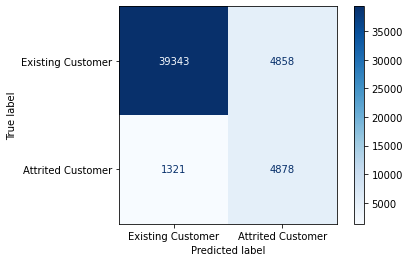

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
labels = ['Existing Customer', 'Attrited Customer']

diagram = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
diagram.plot(cmap=plt.cm.Blues)
plt.show()